In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import gc

In [2]:
%%bash
cd input
ls

item_categories.csv
items.csv
sales_train.csv
sample_submission.csv
shops.csv
test.csv


## Read data files

In [3]:
train = pd.read_csv('./input/sales_train.csv')
test = pd.read_csv('./input/test.csv')
items = pd.read_csv('./input/items.csv')
items_cat = pd.read_csv('./input/item_categories.csv')
shops = pd.read_csv('./input/shops.csv')
samp_sub = pd.read_csv('./input/sample_submission.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [5]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


## Data Cleaning

### Remove outliers from Train set

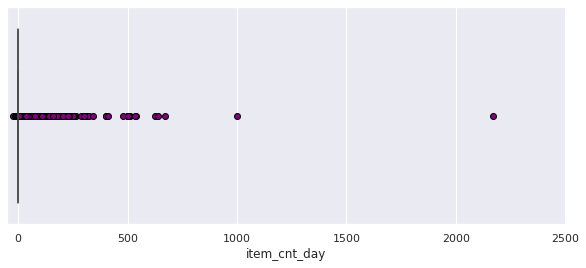

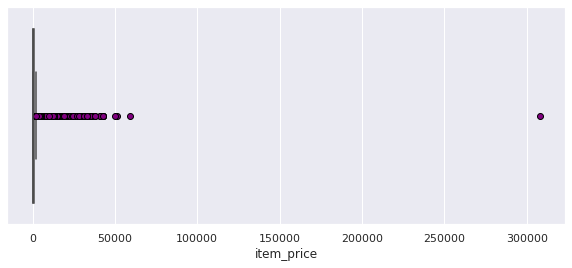

In [6]:
plt.figure(figsize=(10,4))
plt.xlim(-50, 2500)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops);

plt.figure(figsize=(10,4))
sns.boxplot(x=train.item_price, flierprops=flierprops);

### Removing items with negative item_cnt_day or item_price

#### Original data shape

In [7]:
print('Original data contains {} no of rows'.format(train.shape[0]))

Original data contains 2935849 no of rows


#### Removing negative values

In [8]:
mask_neg = (train['item_cnt_day'] < 0) | (train['item_price'] < 0)
train = train.loc[~mask_neg]
print('Cleaned data contains {} no of rows'.format(train.shape[0]))

Cleaned data contains 2928492 no of rows


#### Removing extremely large values

In [9]:
mask_very_large = (train['item_cnt_day'] > 1000) | (train['item_price'] > 50000)
train = train.loc[~mask_very_large]
print('Cleaned data contains {} no of rows'.format(train.shape[0]))

Cleaned data contains 2928488 no of rows


### Add month & year information to the data

In [10]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0


In [11]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')
train.sort_values('date', inplace=True, ignore_index=True)
train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2928483,2015-10-31,33,6,20609,1099.0,1.0
2928484,2015-10-31,33,25,10452,99.0,1.0
2928485,2015-10-31,33,53,1583,3999.0,1.0
2928486,2015-10-31,33,37,7224,4499.0,1.0
2928487,2015-10-31,33,42,3572,1099.0,1.0


In [12]:
train['year'] = getattr(train['date'].dt, 'year')

In [13]:
train['month'] = getattr(train['date'].dt, 'month')

### Drop the date column

In [14]:
train.drop(columns='date', inplace=True)

In [15]:
train = train.groupby(by=['year', 'month', 'shop_id', 'item_id']).agg({'date_block_num': 'mean',
                                                                       'item_cnt_day': 'sum', 
                                                                       'item_price': 'median'})

In [16]:
train.reset_index(inplace=True)

In [17]:
train

,year,month,shop_id,item_id,date_block_num,item_cnt_day,item_price
0,2013,1,0,32,0,6.0,221.0
1,2013,1,0,33,0,3.0,347.0
2,2013,1,0,35,0,1.0,247.0
3,2013,1,0,43,0,1.0,221.0
4,2013,1,0,51,0,2.0,128.5
...,...,...,...,...,...,...,...
1608219,2015,10,59,22087,33,6.0,119.0
1608220,2015,10,59,22088,33,2.0,119.0
1608221,2015,10,59,22091,33,1.0,179.0
1608222,2015,10,59,22100,33,1.0,629.0


In [18]:
train.rename(columns={'item_cnt_day': 'item_cnt_month',
                      'item_price': 'median_monthly_price'}, inplace=True)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608224 entries, 0 to 1608223
Data columns (total 7 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   year                  1608224 non-null  int64  
 1   month                 1608224 non-null  int64  
 2   shop_id               1608224 non-null  int64  
 3   item_id               1608224 non-null  int64  
 4   date_block_num        1608224 non-null  int64  
 5   item_cnt_month        1608224 non-null  float64
 6   median_monthly_price  1608224 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 85.9 MB


In [20]:
train.head()

,year,month,shop_id,item_id,date_block_num,item_cnt_month,median_monthly_price
0,2013,1,0,32,0,6.0,221.0
1,2013,1,0,33,0,3.0,347.0
2,2013,1,0,35,0,1.0,247.0
3,2013,1,0,43,0,1.0,221.0
4,2013,1,0,51,0,2.0,128.5


## Look at shops tables - Correct errors

### Renumber shop_id  - 0 to 57, 1 to 58, 11 to 10, duplicates

In [21]:
train.loc[train.shop_id==0, 'shop_id'] = 57
train.loc[train.shop_id==1, 'shop_id'] = 58
train.loc[train.shop_id==11, 'shop_id'] = 10
train.loc[train.shop_id==40, 'shop_id'] = 39

In [22]:
train.shop_id.nunique()

56

In [25]:
train.to_csv('./input/cleanedmonthly.csv', index=False)